# Estiamcion de precipitación Maxima usando distribuciones de valores extremo tipo1

El analisis de datos historicos de preicpitación puede ser de utilidad para multiples fines, desde la identificación de umbrales de infiltración, pasando por analisis de precipitación hasta análisis de valores extremos. En este caso llevaremos acabo un analisis para identificar la precipitación maxima acumulada en 24 horas; es decir la cantidad de lluvia que puede presentarse en una zona con una probilidad del 1%. Para este analisis se usaran datos de precipitacion diaria acumulada del [IDEAM](http://dhime.ideam.gov.co/atencionciudadano/) desde el año 1960 hasta eñ 2022. Comencemos importado las librerias necesarias.

In [80]:
import os
from pathlib import Path
import pandas as pd
import math
import seaborn  as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gumbel_r
import geopandas as gpd
from shapely.geometry import Point


Importadas las librerias necesarias, el primer lugar vamos a leer los datos de precipitación previamente descargados, *estos se encuentran en forrmato zio en la carpeta de datos de este repositorio* en caso de queree recrear el archivo solo es necesario descomprimir modificar la direccion donde estan los datos

In [401]:
ruta = Path(r"C:\Users\davo2\OneDrive - Procalculo Prosis S.A.S\27. GR\DatosPrecipitacion")
archivos = os.listdir(ruta)
datosCSV = [archivo for archivo in archivos if archivo.endswith('.csv')]

dataframes = [pd.read_csv(ruta.joinpath(archivo), low_memory=False) for archivo in datosCSV]
df = pd.concat(dataframes, ignore_index=True)

df = df[['CodigoEstacion', 'NombreEstacion', 'Latitud', 'Longitud', 'Altitud',
       'Categoria', 'Departamento', 'Municipio',
       'FechaInstalacion', 'FechaSuspension', 'Fecha', 'Valor']]
df["año"] = pd.to_datetime(df.Fecha).dt.year
df['Fecha'] = pd.to_datetime(df['Fecha'])
df["NombreEstacion"] = df['NombreEstacion'].astype(str)
df = df[df.año <= 2023]

df.head(5)

,CodigoEstacion,NombreEstacion,Latitud,Longitud,Altitud,Categoria,Departamento,Municipio,FechaInstalacion,FechaSuspension,Fecha,Valor,año
0,35010020,ACACIAS [35010020],3.994639,-73.765583,525,Pluviométrica,Meta,Acacías,15/04/1961 00:00,NaN,1961-04-01,0.0,1961
1,35010020,ACACIAS [35010020],3.994639,-73.765583,525,Pluviométrica,Meta,Acacías,15/04/1961 00:00,NaN,1961-04-02,0.0,1961
2,35010020,ACACIAS [35010020],3.994639,-73.765583,525,Pluviométrica,Meta,Acacías,15/04/1961 00:00,NaN,1961-04-03,0.0,1961
3,35010020,ACACIAS [35010020],3.994639,-73.765583,525,Pluviométrica,Meta,Acacías,15/04/1961 00:00,NaN,1961-04-04,0.0,1961
4,35010020,ACACIAS [35010020],3.994639,-73.765583,525,Pluviométrica,Meta,Acacías,15/04/1961 00:00,NaN,1961-04-05,0.0,1961


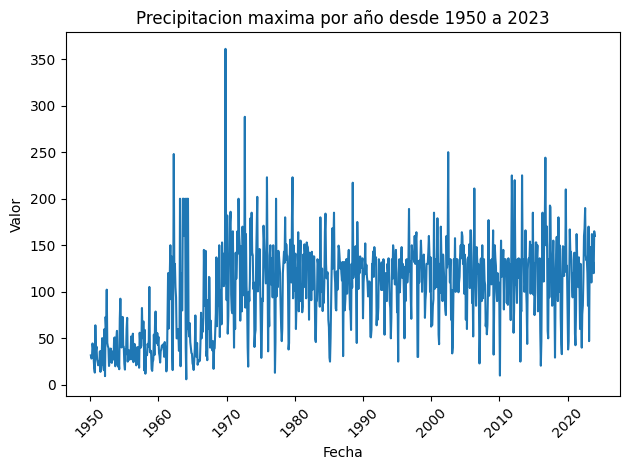

In [402]:
# Convertir la columna 'Fecha' a formato datetime

dff = df.copy()

dff.set_index([ 'Fecha'], inplace=True)
df_numeric = dff.select_dtypes(include=['number'])
df_resampled = df_numeric.resample('ME').max()
sns.lineplot(x=df_resampled.index.get_level_values('Fecha'), 
             y=df_resampled['Valor'], 
            )

# Mostrar la gráfica
plt.xticks(rotation=45)
plt.title("Precipitacion maxima por año desde 1950 a 2023")
plt.tight_layout()
plt.show()


In [531]:
df_resampled

Latitud   Longitud  Altitud  Valor
CodigoEstacion año                                      
21190350       1981  4.152472 -74.359750     2700   51.1
               1982  4.152472 -74.359750     2700   53.8
               1983  4.152472 -74.359750     2700   37.3
               1984  4.152472 -74.359750     2700   88.0
               1985  4.152472 -74.359750     2700   10.4
...                       ...        ...      ...    ...
35060210       2019  4.650250 -73.641444     2100   46.0
               2020  4.650250 -73.641444     2100   41.9
               2021  4.650250 -73.641444     2100   45.5
               2022  4.650250 -73.641444     2100   46.0
               2023  4.650250 -73.641444     2100   42.0

[1811 rows x 4 columns]

In [530]:
dff2= df.copy()

dff2.set_index(['año'], inplace=True)
dff2.reset_index(level='año', inplace=True)

df_numeric = dff2.select_dtypes(include=['number'])
df_resampled = df_numeric.groupby(['CodigoEstacion','año']).max()
sns.lineplot(x=df_resampled.index.get_level_values('año'), 
             y=df_resampled['Valor'], hue= df_resampled.CodigoEstacion)

# Mostrar la gráfica
plt.xticks(rotation=45)
plt.title("Precipitacion maxima por año desde 1950 a 2023")
plt.tight_layout()
plt.show()

AttributeError: 'DataFrame' object has no attribute 'CodigoEstacion'

In [514]:
x = pd.DataFrame(df_resample)

NameError: name 'df_resample' is not defined

In [439]:
cat = df.Categoria.value_counts()
cat

Categoria
Pluviométrica          460447
Pluviográfica          193642
Climática Principal     95969
Agrometeorológica       66930
Climática Ordinaria     56518
Name: count, dtype: int64

In [424]:
estaciones = df.groupby(by=["NombreEstacion", "Latitud", "Longitud"])["Altitud"].mean().reset_index()
precipitacion = df.groupby(by=["NombreEstacion", "Latitud", "Longitud", "año"])["Valor"].max().reset_index()

In [425]:

EstVacios =[]

Estaciones = list(df.NombreEstacion.unique())
for estacion in Estaciones:
    dfsel = precipitacion[precipitacion.NombreEstacion == estacion]

    inicio = dfsel.año.min()
    fin = dfsel.año.max()

    allaños = set(range(inicio, fin + 1))
    añosExis = set(dfsel.año)
    añosFalt = allaños-añosExis

    if len(añosFalt) ==0:
        pass
    else:
        EstVacios.append(estacion)
        filas_faltantes = pd.DataFrame({
        'NombreEstacion': [estacion] * len(añosFalt),
        'Latitud': [dfsel.Latitud.unique()][0][0],
        'Longitud': [dfsel.Longitud.unique()][0][0],
        'año': list(añosFalt),
        'Valor': -1
        })

        precipitacion = pd.concat([precipitacion, filas_faltantes])
        
precipitacion = precipitacion.reset_index(drop=True)
    

In [426]:
precipitacion

,NombreEstacion,Latitud,Longitud,año,Valor
0,ACACIAS [35010020],3.994639,-73.765583,1961,92.0
1,ACACIAS [35010020],3.994639,-73.765583,1962,105.0
2,ACACIAS [35010020],3.994639,-73.765583,1966,145.0
3,ACACIAS [35010020],3.994639,-73.765583,1967,116.0
4,ACACIAS [35010020],3.994639,-73.765583,1968,137.0
...,...,...,...,...,...
1870,EL CALVARIO [35030010],4.352590,-73.713190,1985,-1.0
1871,EL CALVARIO [35030010],4.352590,-73.713190,1986,-1.0
1872,EL CALVARIO [35030010],4.352590,-73.713190,1987,-1.0
1873,EL CALVARIO [35030010],4.352590,-73.713190,1988,-1.0


In [427]:
def calcular_distancia(lat1, lon1, lat2, lon2):
    # Radio de la Tierra en kilómetros
    R = 6371.0

    # Convertir las coordenadas de grados a radianes
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    # Diferencias entre las coordenadas
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Fórmula de Haversine
    a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Distancia
    distance = R * c

    return distance

In [428]:
for estacion in EstVacios:
    for idx in precipitacion[(precipitacion.NombreEstacion == estacion) & (precipitacion.Valor == -1)].index:
        año = precipitacion.loc[idx, 'año']

        EstCercanas = estaciones[estaciones.NombreEstacion != estacion].copy()
        EstCercanas["Lat"] = estaciones[estaciones.NombreEstacion == estacion]["Latitud"].values[0]
        EstCercanas["Lon"] = estaciones[estaciones.NombreEstacion == estacion]["Longitud"].values[0]
        EstCercanas['distancia'] = EstCercanas.apply(lambda row: calcular_distancia(row['Latitud'], row['Longitud'], row['Lat'], row['Lon']), axis=1)
        EstCercanasSel = list(EstCercanas.sort_values(by="distancia")["NombreEstacion"].head(6))

        precipitacion_filtradas = precipitacion[(precipitacion['NombreEstacion'].isin(EstCercanasSel)) & (precipitacion['año'] == año)]
        merged_df = precipitacion_filtradas.merge(EstCercanas[["NombreEstacion","distancia"]], on = 'NombreEstacion', how = 'inner')
        merged_df["alfa"] = (1/pow(merged_df.distancia,2))/sum(1/pow(merged_df.distancia,2))
        estimado = sum(merged_df.Valor*merged_df.alfa)

        precipitacion.loc[idx, "Valor"] = estimado

In [429]:
precipitacion = precipitacion.sort_values(by=["NombreEstacion", "año"]).reset_index(drop=True)

In [430]:
estaciones["Predicho"] = 0
estaciones["Ajuste"] = ""
estaciones["R2"] = ""
ajuste = 0


In [431]:

for estacion in Estaciones:
    data = precipitacion[precipitacion.NombreEstacion == estacion]["Valor"]
    N = len(data)
    miu, alfa = gumbel_r.fit(data)
    varianza = sum(pow(data - data.mean(),2))/(N-1)
    VPREDICT = miu + alfa*(-np.log(np.log(100/99)))

    #Calculo factores de ajuste

    PEMPIRICA = np.zeros(N)
    for i in range(N):
        PEMPIRICA[i] = i/(N+1)

    VECTORA = np.zeros(N)
    VECTORA = np.sort(data)

    PACUMULADA = np.zeros(N)
    for i in range(N):
        PACUMULADA[i] = np.exp(-np.exp(-(VECTORA[i] - miu) /alfa))

    delta = abs(PEMPIRICA - PACUMULADA)
    DELTA = np.sort(delta)[::-1]

    VECTORC = np.array([0.97500, 0.84189, 0.70760, 0.62394, 0.56328, 0.51926, 0.48342, 0.45427, 0.43001, 0.40925,
                    0.39122, 0.37543, 0.36143, 0.34890, 0.33750, 0.32733, 0.31796, 0.30936, 0.30143, 0.29408,
                    0.28724, 0.28087, 0.2749, 0.26931, 0.26404, 0.25908, 0.25438, 0.24993, 0.24571, 0.24170,
                    0.23788, 0.23424, 0.23076, 0.22743, 0.22425, 0.22119, 0.21826, 0.21544, 0.21273, 0.21012,
                    0.20760, 0.20517, 0.20283, 0.20056, 0.19837, 0.19625, 0.19420, 0.19221, 0.19028, 0.18841])

    if N<51:
        DELTAT = VECTORC[N-1]
    else:
        DELTAT = 1.36/math.sqrt(N)

    if DELTAT > DELTA[0]:
        ajuste = "SI"
    else:
        ajuste = "NO"
            
    R1  = np.zeros(N)
    R2 = np.zeros(N)
    
    for i in range(N):
        R1[i] = pow(PEMPIRICA[i] -PACUMULADA[i], 2)
        R2[i] = pow(PEMPIRICA[i] - np.mean(PEMPIRICA),2)
    RCUA = 1-(np.sum(R1)/np.sum(R2))

    estaciones.loc[estaciones.NombreEstacion == estacion, "Predicho"] = VPREDICT
    estaciones.loc[estaciones.NombreEstacion == estacion, "Ajuste"] = ajuste
    estaciones.loc[estaciones.NombreEstacion == estacion, "R2"] = RCUA

C:\Users\davo2\AppData\Local\Temp\ipykernel_26800\3582883449.py:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '265.68677735571583' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  estaciones.loc[estaciones.NombreEstacion == estacion, "Predicho"] = VPREDICT


In [432]:
estaciones

,NombreEstacion,Latitud,Longitud,Altitud,Predicho,Ajuste,R2
0,ACACIAS [35010020],3.994639,-73.765583,525.0,265.686777,NO,0.83091
1,AUSTRALIA [21201300],4.394250,-74.132000,3050.0,62.224064,SI,0.956901
2,BETANIA [35020350],4.218889,-74.146861,3150.0,69.775544,SI,0.976378
3,CASITA LA [21201120],4.633333,-74.016667,3045.0,106.157354,SI,0.964128
4,CAÑO HONDO [35010040],3.925070,-73.813620,639.0,245.893616,SI,0.97437
5,CHIPAQUE [35020050],4.450000,-74.050000,2850.0,61.529602,SI,0.973427
6,CHOACHI [35020240],4.533333,-73.933333,1950.0,63.299286,SI,0.985791
7,CHOACHI [35020280],4.522917,-73.926583,1950.0,80.671294,SI,0.971066
8,CLARAVAL [35060210],4.650250,-73.641444,2100.0,82.255609,SI,0.967126
9,CUCHILLA GOLILLAS [35030120],4.566667,-73.733333,3350.0,106.465227,SI,0.955182


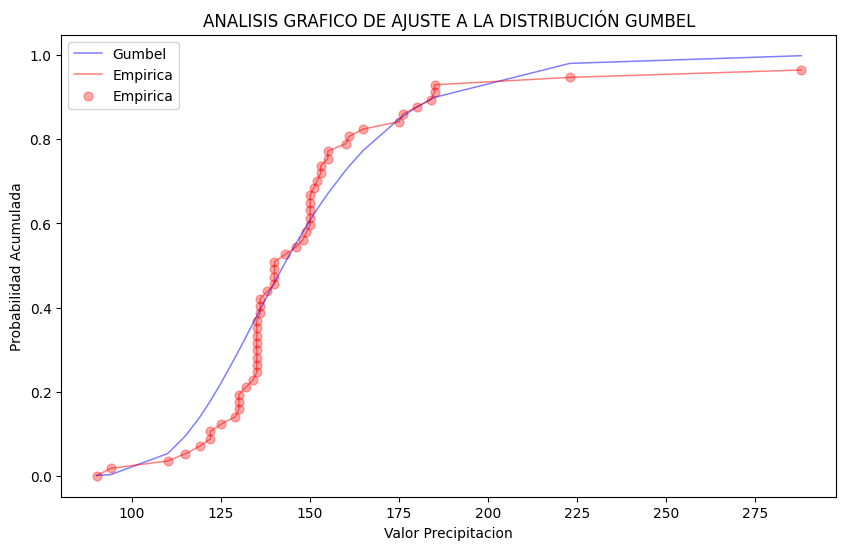

,variable,valor
0,Varianza,871.963312
1,Beta,134.312971
2,Alfa,22.535722
3,Prediccion,237.980654
4,Delta Calculado,0.141644
5,Delta Tabla,0.181738
6,Coeficiente de Determinacion,0.944818
7,Numero de Datos,56.000000


In [433]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Crear los dataframes df1 y df2
df1 = pd.DataFrame({'VECTORA': VECTORA, 'PACUMULADA': PACUMULADA})
df2 = pd.DataFrame({'VECTORA': VECTORA, 'PEMPIRICA': PEMPIRICA})

# Preparación de la gráfica
plt.figure(figsize=(10, 6))

# Graficar PACUMULADA
plt.plot(df1['VECTORA'], df1['PACUMULADA'], label='Gumbel', color='blue', linewidth=1.1, alpha=1/2)

# Graficar PEMPIRICA
plt.plot(df2['VECTORA'], df2['PEMPIRICA'], label='Empirica', color='red', linewidth=1.1, alpha=1/2)

# Puntos de datos de PEMPIRICA
plt.scatter(df2['VECTORA'], df2['PEMPIRICA'], label='Empirica', color='red', s=40, alpha=1/3)

# Configuración de etiquetas y título
plt.title("ANALISIS GRAFICO DE AJUSTE A LA DISTRIBUCIÓN GUMBEL")
plt.xlabel("Valor Precipitacion")
plt.ylabel("Probabilidad Acumulada")
plt.legend()

# Mostrar la gráfica
plt.show()

# Crear el dataframe RESUL
RESUL = pd.DataFrame({'variable': ["Varianza", "Beta", "Alfa", "Prediccion", "Delta Calculado", "Delta Tabla", 
                                   "Coeficiente de Determinacion", "Numero de Datos"],
                      'valor': [varianza, miu, alfa,  VPREDICT , DELTA[0], DELTAT, RCUA, N]})

RESUL


In [434]:
geometry = [Point(xy) for xy in zip(estaciones['Longitud'], estaciones['Latitud'])]
gdf = gpd.GeoDataFrame(estaciones, geometry=geometry)
gdf.set_crs(epsg=4326, inplace=True)
gdf.to_file("estaciones.shp")


C:\Users\davo2\AppData\Local\Temp\ipykernel_26800\1876959993.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file("estaciones.shp")
